In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import numpy as np
import seaborn as sns

# Process Results

In [2]:
project_path = "../speech_hypertuning/experiments/audios_per_sid_vs_hidden_size/"

In [3]:
states_paths = Path(project_path).rglob('*state.pkl')
states = {}
for path in states_paths:
    experiment_name = path.parent.name
    if experiment_name not in states:
        state = joblib.load(path)
        states[experiment_name] = state

In [4]:
states_wo_test_metrics = {exp_name: state for exp_name, state in states.items() if not 'test_metrics' in state or state['test_metrics'] is None}
print(f"{len(states_wo_test_metrics)} states wo test metrics")
states = {k: v for k,v in states.items() if k not in states_wo_test_metrics}

0 states wo test metrics


In [5]:
test_losses = {}
acc_top1 = {}
acc_top5 = {}
execution_times = {}
for exp_name, state in states.items():
    n, hidden_size = exp_name.split("-")
    n, hidden_size = n.split("_")[-1], hidden_size.split("_")[-1]
    
    if n not in test_losses:
        test_losses[n] = {}
        acc_top1[n] = {}
        acc_top5[n] = {}
        execution_times[n] = {}
    
    metrics = state['test_metrics'][0]
    test_losses[n][hidden_size] = metrics['test_loss']
    acc_top1[n][hidden_size] = metrics['test_accuracy_top1']
    acc_top5[n][hidden_size] = metrics['test_accuracy_top5']
    execution_times[n][hidden_size] = state['execution_times']["fit_model_0"]['process_time'] / 60 / 60

In [6]:
def get_matrix_from_dict(metrics_dict, keys1, keys2):
    return [
        [
            metrics_dict[str(key1)][str(key2)] if str(key1) in metrics_dict and str(key2) in metrics_dict[str(key1)] else np.nan 
            for key2 in keys2
        ] for key1 in keys1
    ]

In [7]:
ns = [150, 100, 75, 50, 30, 20, 10, 5, 1]
hidden_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
test_losses_matrix = get_matrix_from_dict(test_losses, ns, hidden_sizes)
test_acc1_matrix = get_matrix_from_dict(acc_top1, ns, hidden_sizes)
test_acc5_matrix = get_matrix_from_dict(acc_top5, ns, hidden_sizes)
prior_distribution_entropy = -np.log(1 / 100)  # WARNING: Only true for balanced datasets
test_normalized_losses_matrix = [[x / prior_distribution_entropy for x in row] for row in test_losses_matrix]
execution_times_matrix = get_matrix_from_dict(execution_times, ns, hidden_sizes)

In [8]:
data = {ns: hidden_size_losses for ns, hidden_size_losses in zip(ns, test_acc1_matrix)}
data['hidden_sizes'] = hidden_sizes
df = pd.DataFrame.from_dict(data)
df.set_index('hidden_sizes', inplace=True)
df

,150,100,75,50,30,20,10,5,1
hidden_sizes,,,,,,,,,
1,0.009862,0.009862,0.009862,0.009862,0.009862,0.010519,0.009862,0.016108,0.014135
2,0.209402,0.174885,0.146943,0.113083,0.070677,0.060158,0.029915,0.024326,0.007561
4,0.529586,0.471729,0.446417,0.268245,0.307364,0.230769,0.090401,0.044707,0.014135
8,0.762656,0.717620,0.661736,0.610782,0.512492,0.403682,0.233070,0.096976,0.020710
16,0.904997,0.863577,0.837936,0.781723,0.704799,0.579882,0.393491,0.193951,0.037475
32,0.955293,0.932281,0.914201,0.859632,0.776463,0.683761,0.520381,0.327416,0.039776
64,0.967127,0.952334,0.935240,0.900723,0.831690,0.762656,0.619001,0.406312,0.091716
128,0.978632,0.964826,0.952663,0.927350,0.868179,0.804405,0.660092,0.455950,0.135437
256,0.985865,0.978961,0.964497,0.951019,0.899737,0.840894,0.712360,0.494740,0.152531


In [9]:
df2 = pd.DataFrame.transpose(df)
df2

hidden_sizes,1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192
150,0.009862,0.209402,0.529586,0.762656,0.904997,0.955293,0.967127,0.978632,0.985865,0.988494,0.989481,0.991453,0.991453,0.991782
100,0.009862,0.174885,0.471729,0.717620,0.863577,0.932281,0.952334,0.964826,0.978961,0.984878,0.987508,0.987508,0.986851,0.986851
75,0.009862,0.146943,0.446417,0.661736,0.837936,0.914201,0.935240,0.952663,0.964497,0.979947,0.982249,0.982906,0.983563,0.983563
50,0.009862,0.113083,0.268245,0.610782,0.781723,0.859632,0.900723,0.927350,0.951019,0.968113,0.972387,0.975345,0.974359,0.976331
30,0.009862,0.070677,0.307364,0.512492,0.704799,0.776463,0.831690,0.868179,0.899737,0.928665,0.939842,0.946417,0.946417,0.952005
20,0.010519,0.060158,0.230769,0.403682,0.579882,0.683761,0.762656,0.804405,0.840894,0.876726,0.894806,0.901381,0.911243,0.914201
10,0.009862,0.029915,0.090401,0.233070,0.393491,0.520381,0.619001,0.660092,0.712360,0.735043,0.759369,0.772518,0.785339,0.796844
5,0.016108,0.024326,0.044707,0.096976,0.193951,0.327416,0.406312,0.455950,0.494740,0.530243,0.553583,0.570677,0.582183,0.593688
1,0.014135,0.007561,0.014135,0.020710,0.037475,0.039776,0.091716,0.135437,0.152531,0.164694,0.168968,0.174227,0.181131,0.188692


# Plots

[Text(0.5, 23.52222222222222, 'Hidden sizes'),
 Text(50.722222222222214, 0.5, 'Audios per speaker in train')]

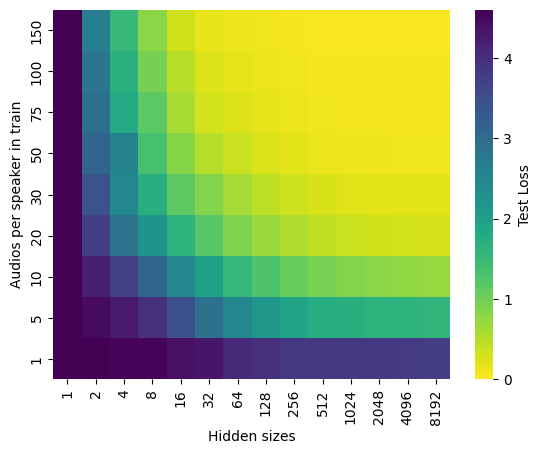

In [10]:
ax = sns.heatmap(np.array(test_losses_matrix), xticklabels=hidden_sizes, yticklabels=ns, cmap='viridis_r',vmin=0, vmax=4.6, cbar_kws={'label': 'Test Loss'})
ax.set(xlabel="Hidden sizes", ylabel="Audios per speaker in train")

[Text(0.5, 23.52222222222222, 'Hidden sizes'),
 Text(50.722222222222214, 0.5, 'Audios per speaker in train')]

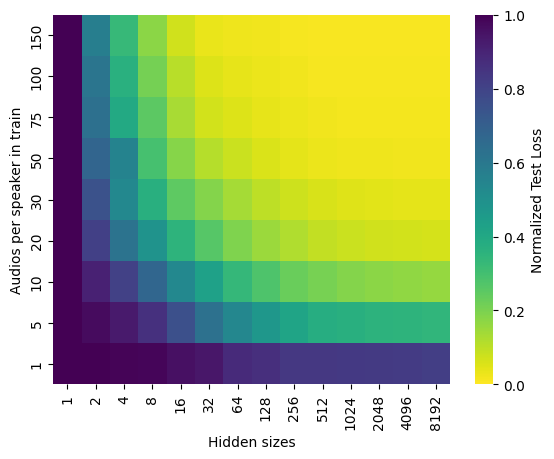

In [11]:
ax = sns.heatmap(np.array(test_normalized_losses_matrix), xticklabels=hidden_sizes, yticklabels=ns, cmap='viridis_r', vmin=0, vmax=1, cbar_kws={'label': 'Normalized Test Loss'})
ax.set(xlabel="Hidden sizes", ylabel="Audios per speaker in train")

[Text(0.5, 23.52222222222222, 'Hidden sizes'),
 Text(50.722222222222214, 0.5, 'Audios per speaker in train')]

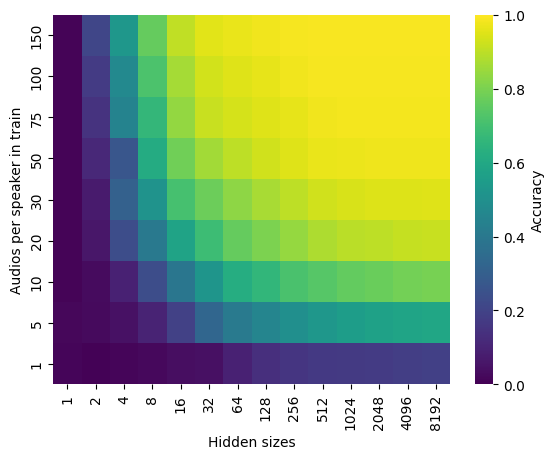

In [12]:
ax = sns.heatmap(np.array(test_acc1_matrix), xticklabels=hidden_sizes, yticklabels=ns, cmap='viridis', vmin=0., vmax=1, cbar_kws={'label': 'Accuracy'})
ax.set(xlabel="Hidden sizes", ylabel="Audios per speaker in train")

[Text(0.5, 23.52222222222222, 'Hidden sizes'),
 Text(50.722222222222214, 0.5, 'Audios per speaker in train')]

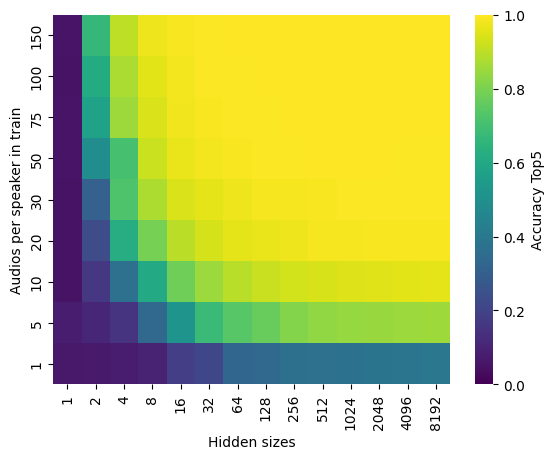

In [13]:
ax = sns.heatmap(np.array(test_acc5_matrix), xticklabels=hidden_sizes, yticklabels=ns, cmap='viridis', vmin=0., vmax=1, cbar_kws={'label': 'Accuracy Top5'})
ax.set(xlabel="Hidden sizes", ylabel="Audios per speaker in train")

[Text(0.5, 23.52222222222222, 'Hidden sizes'),
 Text(50.722222222222214, 0.5, 'Audios per speaker in train')]

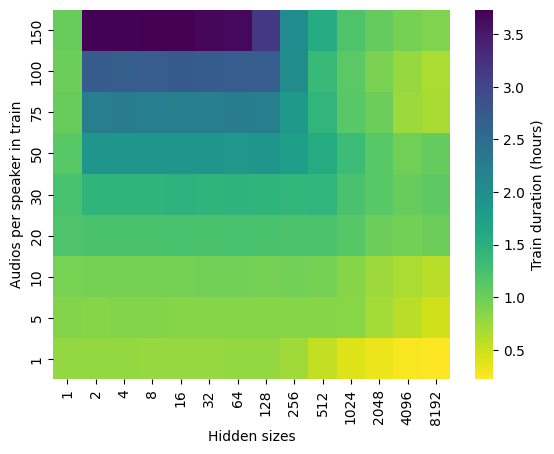

In [14]:
ax = sns.heatmap(np.array(execution_times_matrix), xticklabels=hidden_sizes, yticklabels=ns, cmap='viridis_r', cbar_kws={'label': 'Train duration (hours)'})
ax.set(xlabel="Hidden sizes", ylabel="Audios per speaker in train")

In [15]:
execution_times['30']['8192']

1.0945702381802778

In [16]:
execution_times['150']['16']

3.728491523508333

In [17]:
execution_times['150']['4096']

0.9470064009763889

In [18]:
execution_times['150']['8192']

0.8937393846905555

In [19]:
s = states['audios_per_sid_150-hidden_size_8192']
df = s['dataset_metadata'].copy()
df

,Unnamed: 0,index,filename,sr,channels,frames,duration,speaker_id,video_id,segment_id,VGGFace1 ID,Gender,Nationality,dataset,rel_path,set
0,141482,141482,/datasets/Voxceleb1/wav/id10986/Gq881M1WnKM/00...,16000,1,111361,6.960063,id10986,Gq881M1WnKM,3,Rob_Reiner,m,USA,voxceleb1,wav/id10986/Gq881M1WnKM/00003.wav,validation
1,141696,141696,/datasets/Voxceleb1/wav/id10986/6SBGrr4iFp0/00...,16000,1,65921,4.120063,id10986,6SBGrr4iFp0,30,Rob_Reiner,m,USA,voxceleb1,wav/id10986/6SBGrr4iFp0/00030.wav,validation
2,141820,141820,/datasets/Voxceleb1/wav/id10986/lFEBeMFuL_M/00...,16000,1,88961,5.560062,id10986,lFEBeMFuL_M,17,Rob_Reiner,m,USA,voxceleb1,wav/id10986/lFEBeMFuL_M/00017.wav,validation
3,141645,141645,/datasets/Voxceleb1/wav/id10986/KH-yJAsKo1Q/00...,16000,1,553601,34.600062,id10986,KH-yJAsKo1Q,12,Rob_Reiner,m,USA,voxceleb1,wav/id10986/KH-yJAsKo1Q/00012.wav,validation
4,141389,141389,/datasets/Voxceleb1/wav/id10986/sOlWHKGy-SY/00...,16000,1,144641,9.040062,id10986,sOlWHKGy-SY,66,Rob_Reiner,m,USA,voxceleb1,wav/id10986/sOlWHKGy-SY/00066.wav,validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153511,138942,138942,/datasets/Voxceleb1/wav/id11229/zO6sDDC8jDw/00...,16000,1,120961,7.560062,id11229,zO6sDDC8jDw,7,Will_Mellor,m,UK,voxceleb1,wav/id11229/zO6sDDC8jDw/00007.wav,train
153512,138911,138911,/datasets/Voxceleb1/wav/id11229/hMMde0Vtg-M/00...,16000,1,136321,8.520062,id11229,hMMde0Vtg-M,2,Will_Mellor,m,UK,voxceleb1,wav/id11229/hMMde0Vtg-M/00002.wav,train
153513,138922,138922,/datasets/Voxceleb1/wav/id11229/AiJinimEdKA/00...,16000,1,299521,18.720063,id11229,AiJinimEdKA,1,Will_Mellor,m,UK,voxceleb1,wav/id11229/AiJinimEdKA/00001.wav,train
153514,138943,138943,/datasets/Voxceleb1/wav/id11229/zO6sDDC8jDw/00...,16000,1,126081,7.880063,id11229,zO6sDDC8jDw,4,Will_Mellor,m,UK,voxceleb1,wav/id11229/zO6sDDC8jDw/00004.wav,train


In [33]:
n_speakers = 1000
df = s['dataset_metadata'].copy()
speakers = df.speaker_id.unique().tolist()[:n_speakers]

In [42]:
df2 = df[(df.speaker_id.isin(speakers)) & (df.set == "train") & (df.duration < 20)].copy()
sid_to_audios_count = df2.groupby(['speaker_id']).size().to_dict()

In [43]:
min(list(sid_to_audios_count.values()))

33

In [45]:
df3 = df[(df.speaker_id.isin(speakers)) & (df.set == "validation") & (df.duration < 30)].copy()
sid_to_audios_count = df3.groupby(['speaker_id']).size().to_dict()
min(list(sid_to_audios_count.values()))

8

In [46]:
df3 = df[(df.speaker_id.isin(speakers)) & (df.set == "test") & (df.duration < 30)].copy()
sid_to_audios_count = df3.groupby(['speaker_id']).size().to_dict()
min(list(sid_to_audios_count.values()))

7

In [38]:
sid_to_audios_count

{'id10001': 8,
 'id10002': 19,
 'id10003': 25,
 'id10004': 14,
 'id10006': 15,
 'id10007': 12,
 'id10008': 13,
 'id10011': 17,
 'id10012': 22,
 'id10014': 13,
 'id10015': 9,
 'id10016': 33,
 'id10017': 21,
 'id10018': 39,
 'id10019': 10,
 'id10020': 82,
 'id10021': 21,
 'id10022': 30,
 'id10024': 11,
 'id10026': 8,
 'id10027': 9,
 'id10029': 20,
 'id10030': 12,
 'id10031': 26,
 'id10032': 13,
 'id10033': 7,
 'id10034': 12,
 'id10035': 20,
 'id10036': 19,
 'id10037': 19,
 'id10038': 21,
 'id10039': 6,
 'id10040': 5,
 'id10041': 24,
 'id10042': 12,
 'id10043': 9,
 'id10044': 36,
 'id10045': 44,
 'id10046': 8,
 'id10047': 21,
 'id10048': 19,
 'id10050': 10,
 'id10052': 26,
 'id10053': 19,
 'id10054': 18,
 'id10055': 28,
 'id10056': 17,
 'id10059': 22,
 'id10061': 37,
 'id10062': 22,
 'id10063': 16,
 'id10064': 13,
 'id10066': 15,
 'id10067': 15,
 'id10068': 10,
 'id10071': 23,
 'id10072': 13,
 'id10073': 8,
 'id10074': 14,
 'id10077': 14,
 'id10078': 18,
 'id10079': 14,
 'id10080': 18,
 '

In [41]:
df[df.speaker_id == "id10040"]

,Unnamed: 0,index,filename,sr,channels,frames,duration,speaker_id,video_id,segment_id,VGGFace1 ID,Gender,Nationality,dataset,rel_path,set
128132,81805,81805,/datasets/Voxceleb1/wav/id10040/pEMxNj4acCI/00...,16000,1,74241,4.640062,id10040,pEMxNj4acCI,1,Allison_Williams,f,USA,voxceleb1,wav/id10040/pEMxNj4acCI/00001.wav,validation
128133,81833,81833,/datasets/Voxceleb1/wav/id10040/Cu1Gugj18Vg/00...,16000,1,88961,5.560062,id10040,Cu1Gugj18Vg,3,Allison_Williams,f,USA,voxceleb1,wav/id10040/Cu1Gugj18Vg/00003.wav,validation
128134,81803,81803,/datasets/Voxceleb1/wav/id10040/U8_38kaSJy0/00...,16000,1,109441,6.840063,id10040,U8_38kaSJy0,1,Allison_Williams,f,USA,voxceleb1,wav/id10040/U8_38kaSJy0/00001.wav,validation
128135,81791,81791,/datasets/Voxceleb1/wav/id10040/bK5SCGBMN4U/00...,16000,1,97921,6.120063,id10040,bK5SCGBMN4U,1,Allison_Williams,f,USA,voxceleb1,wav/id10040/bK5SCGBMN4U/00001.wav,validation
128136,81811,81811,/datasets/Voxceleb1/wav/id10040/DMBems4y_p0/00...,16000,1,81281,5.080063,id10040,DMBems4y_p0,1,Allison_Williams,f,USA,voxceleb1,wav/id10040/DMBems4y_p0/00001.wav,validation
128137,81794,81794,/datasets/Voxceleb1/wav/id10040/cIapgK3jseo/00...,16000,1,115201,7.200062,id10040,cIapgK3jseo,1,Allison_Williams,f,USA,voxceleb1,wav/id10040/cIapgK3jseo/00001.wav,validation
128138,81817,81817,/datasets/Voxceleb1/wav/id10040/Yr6vOaWRSb0/00...,16000,1,216961,13.560063,id10040,Yr6vOaWRSb0,1,Allison_Williams,f,USA,voxceleb1,wav/id10040/Yr6vOaWRSb0/00001.wav,validation
128139,81796,81796,/datasets/Voxceleb1/wav/id10040/4mkRl_p-rnQ/00...,16000,1,70401,4.400062,id10040,4mkRl_p-rnQ,2,Allison_Williams,f,USA,voxceleb1,wav/id10040/4mkRl_p-rnQ/00002.wav,validation
128140,81787,81787,/datasets/Voxceleb1/wav/id10040/nmEj7IkWbD4/00...,16000,1,69121,4.320062,id10040,nmEj7IkWbD4,10,Allison_Williams,f,USA,voxceleb1,wav/id10040/nmEj7IkWbD4/00010.wav,validation
128141,81786,81786,/datasets/Voxceleb1/wav/id10040/nmEj7IkWbD4/00...,16000,1,320641,20.040063,id10040,nmEj7IkWbD4,7,Allison_Williams,f,USA,voxceleb1,wav/id10040/nmEj7IkWbD4/00007.wav,test


In [40]:
pd.set_option('display.max_rows', 200)